# Sentiment Analysis on News Headlines, Descriptions of Most Liquid Stocks 

This is the exporatory data analysis portion.
Sentiment Analysis has been performed on headlines and descriptions of news articles on the most liquid stocks. Polarity and subjectivity scores have been added as variables in the csv for each of the stocks.
We will analyze the relationships between volume of news, polarity, subjectivity and stock price.

#### Gathering data involved scraping: http://www.wsj.com/mdc/public/page/2_3021-activnyse-actives.html

#### Pysentiment was used to retrieve scores for polarity and subjectivity of each news headline/description. Pysentiment is a package that contains a financial sentiment dicitionarys. For more on Pysentiment: https://pypi.org/project/pysentiment/

In [7]:
from dateutil import parser
import seaborn as sns
import matplotlib as plt
sns.set(style='whitegrid', palette='Set2')

## Configure api key from Quandl, Set Start and End Dates

In [2]:
import quandl
import datetime

# register for a free account at quandl.com for an api key
quandl.ApiConfig.api_key = "Y3HQBnRJZFqT4QNUyFsr"

# import DataReader to get stock prices
from pandas_datareader.data import DataReader

start = datetime.datetime(2018,9,16)
end = datetime.datetime(2018,10,15)

## Create Tuple of Name of Stock and its' CSV file

In [3]:
import pandas as pd

# Read csv of 100 most liquid stocks into dataframe called top100liquid
top100liquid = pd.read_csv('top100liquid.csv', header = None)


# drop all stocks with nan values, and set range from 0 to 100
top100liquid.dropna(axis=0,inplace=True)
top100liquid.index = range(len(top100liquid.index))

# Slice top 10 most liquid stocks to new dataframe called top10
top10 = top100liquid[:10]
top10.columns = ['stock','volume']

# Get list of stock names from top10, and remove AT&T
# the & in AT&T will result in error with newsapi 
l = top10['stock'].tolist()
l = [lst.split('(')[:-1][0].strip() for lst in l]

# pop AT&T
l.pop(3)
l[-1] = l[-1][:-4]
# fix asset names, Square = Square Inc, Snap = Snap Inc
# Square and Snap alone will result in many irrelevant results
l[3] = 'Square Inc'
l[4] = 'Snap Inc'

# create list of tuples called lst
lst = [(stock, stock+'.csv') for stock in l]
lst

[('General Electric', 'General Electric.csv'),
 ('Bank of America', 'Bank of America.csv'),
 ('Ford Motor', 'Ford Motor.csv'),
 ('Square Inc', 'Square Inc.csv'),
 ('Snap Inc', 'Snap Inc.csv'),
 ('Wells Fargo', 'Wells Fargo.csv'),
 ('JPMorgan Chase', 'JPMorgan Chase.csv'),
 ('Freeport-McMoRan', 'Freeport-McMoRan.csv'),
 ('Alibaba Group Holding', 'Alibaba Group Holding.csv')]

## Create Dictionary of Stock News Dataframes

In [8]:
# for each asset read in data from corresponding csv
# each dataframe is assigned to as the value of the stock in stockdfs dictionary
stockdfs = {}
for stock, stockcsv in lst:
    stockdfs[stock] = pd.read_csv(stockcsv)
    
# convert the 'date' column of each dataframe to format: Y-M-D
for df in stockdfs.values():
    df['date'] = df.apply(lambda x: parser.parse(x['publishedAt']).strftime('%Y-%m-%d'),axis=1)

## Create Tickers for Each Asset and Empty Stock Prices Dictionary

In [6]:
# list of tickers for 9 of 10 most liquid assets
tickers = ['GE','BAC','F', 'SQ', 'SNAP', 'WFC','JPM','FCX','BABA',]
tickers = list(zip(l,tickers))

# create empty dictionary to store stock prices dataframe
stockpricedict = {key: None for key in l}
print(tickers, '\n')
print(stockpricedict)

[('General Electric', 'GE'), ('Bank of America', 'BAC'), ('Ford Motor', 'F'), ('Square Inc', 'SQ'), ('Snap Inc', 'SNAP'), ('Wells Fargo', 'WFC'), ('JPMorgan Chase', 'JPM'), ('Freeport-McMoRan', 'FCX'), ('Alibaba Group Holding', 'BABA')] 

{'General Electric': None, 'Bank of America': None, 'Ford Motor': None, 'Square Inc': None, 'Snap Inc': None, 'Wells Fargo': None, 'JPMorgan Chase': None, 'Freeport-McMoRan': None, 'Alibaba Group Holding': None}


In [7]:
# get stock prices for each stock for period from 2018-09-16 to 2018-10-15
for stock, tick in tickers:
    stockpricedict[stock] = DataReader(tick,'yahoo', start, end)

## JPMorgan Chase

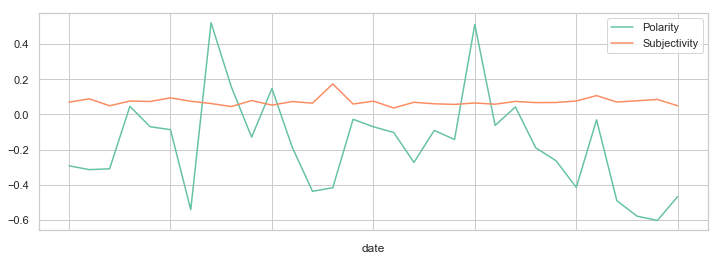

In [16]:
# aggregate the polarity and subjectivity scores for mean polarity and subjectivity scores for all news headlines on each day
jpm = stockdfs['JPMorgan Chase']
jpmpolsub = jpm.groupby(by = 'date').mean()[['Polarity','Subjectivity']]
# plot polarity of subjectivity over the past month
jpmpolsub.plot(figsize=(12,4), sharey= True)

C:\Users\VL21\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


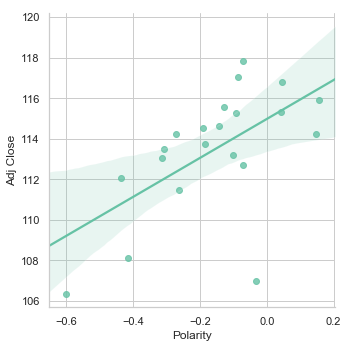

In [84]:
# merge daily mean polarity/subjectivity dataframe, jpmpolsub, with stock price dataframe
mergedf = stockpricedict['JPMorgan Chase'].reset_index().merge(jpmpolsub, how = 'left', left_on = 'Date', right_on = 'date' )
mergedf = mergedf[['Date','Polarity', 'Subjectivity', 'Adj Close']].set_index('Date')
# plot mean daily polarity vs closing stock price
sns.lmplot(x="Polarity", y="Adj Close", data=mergedf)

### Polarity is positively correlated with closing price. 

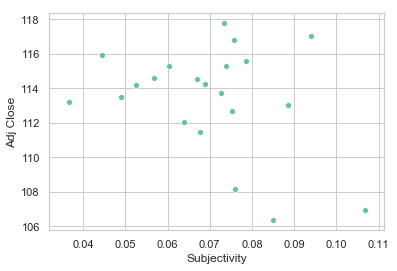

In [83]:
sns.lmplot(x="Subjectivity", y="Adj Close", data=mergedf)

### Subjectivity is slightly negatively correlated to closing price.

## Distribution of News for JPMorgan Chase

In [9]:
# convert 'date' column of dataframes to datetime objects
for df in stockdfs.values():
    df['date'] = pd.to_datetime(df['date'])

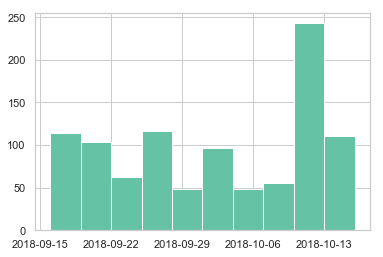

In [10]:
stockdfs['JPMorgan Chase']['date'].hist()

### Large volumes of news on a topic is an event. We can see increases in news articles on a topic usually in reaction to something.

In [10]:
closejpm = stockpricedict['JPMorgan Chase']['Adj Close']

## Closing Stock Price of JPMorgan Chase from 2018-09-16 to 2018-10-15

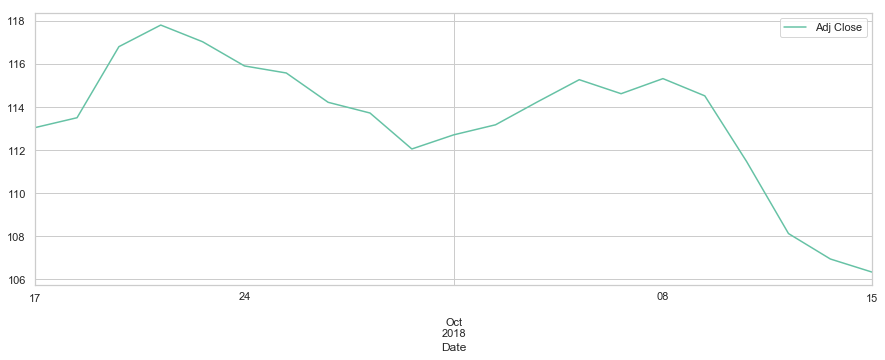

In [33]:
closejpm.plot(xlim = ['2018-09-16', '2018-10-15'],legend = True, figsize = (15,4))

## Same Analysis for Wells Fargo and General Electric

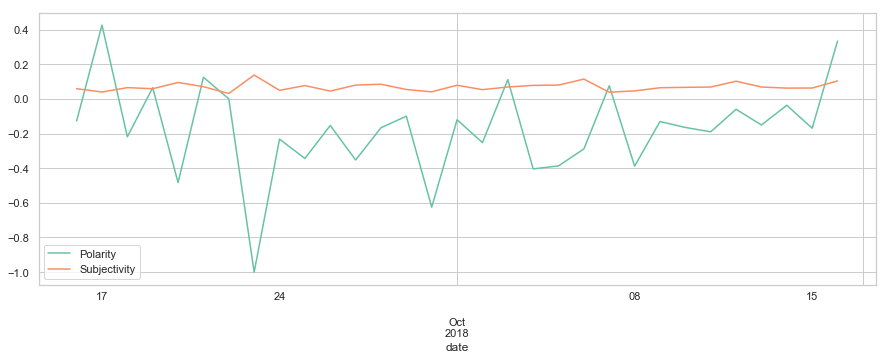

In [85]:
wellsfargo = stockdfs['Wells Fargo']
wellsfargopolsub = wellsfargo.groupby(by = 'date').mean()[['Polarity','Subjectivity']]
wellsfargopolsub.plot(figsize=(15,5), sharey= True)

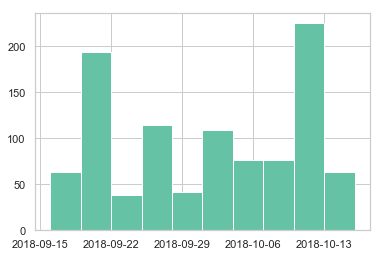

In [87]:
wellsfargo['date'].hist()

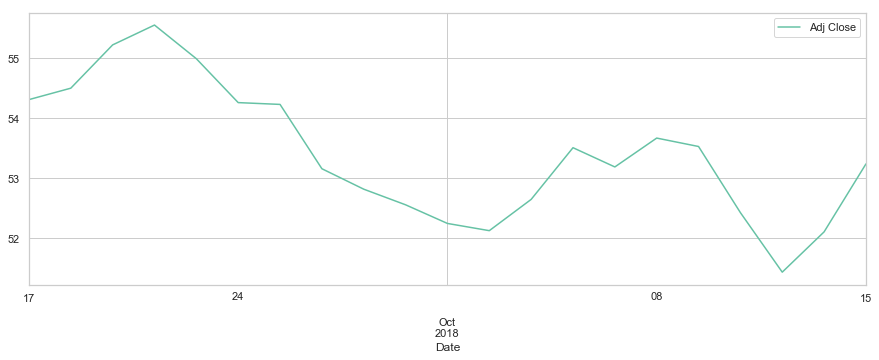

In [88]:
stockpricedict['Wells Fargo']['Adj Close'].plot(xlim = ['2018-09-16', '2018-10-15'],legend = True, figsize = (15,5))

C:\Users\VL21\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


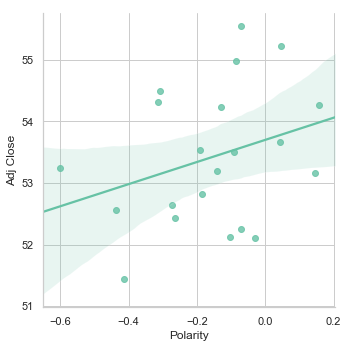

In [89]:
mergedf2 = stockpricedict['Wells Fargo'].reset_index().merge(jpmpolsub, how = 'left', left_on = 'Date', right_on = 'date' )
mergedf2 = mergedf2[['Date','Polarity', 'Subjectivity', 'Adj Close']].set_index('Date')
sns.lmplot(x="Polarity", y="Adj Close", data=mergedf2)

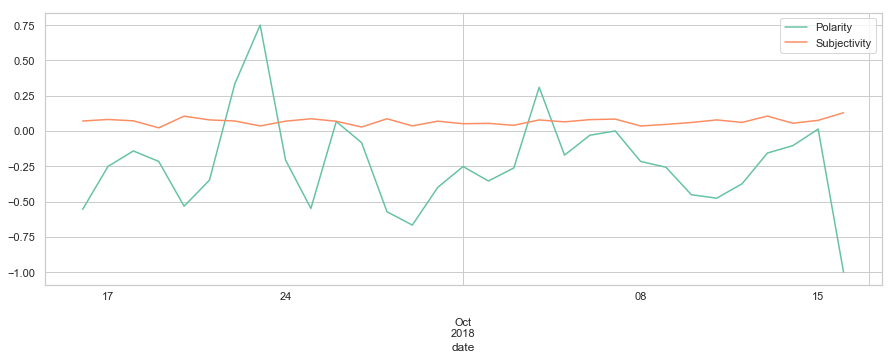

In [94]:
ge = stockdfs['General Electric'].groupby(by = 'date').mean()[['Polarity','Subjectivity']]
ge.plot(figsize=(15,5), sharey= True)

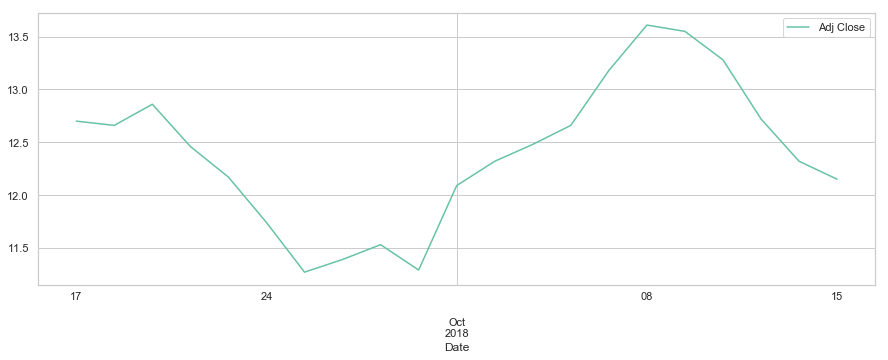

In [76]:
stockpricedict['General Electric']['Adj Close'].plot(legend = True, figsize = (15,5))

C:\Users\VL21\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


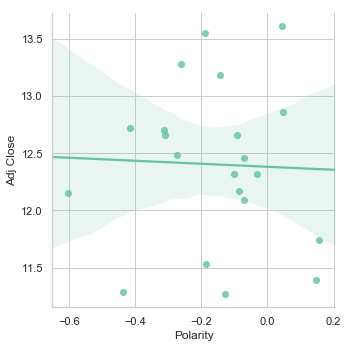

In [90]:
mergedf3 = stockpricedict['General Electric'].reset_index().merge(jpmpolsub, how = 'left', left_on = 'Date', right_on = 'date' )
mergedf3 = mergedf3[['Date','Polarity', 'Subjectivity', 'Adj Close']].set_index('Date')
sns.lmplot(x="Polarity", y="Adj Close", data=mergedf3)

## Analysis

There is a lag, price lags behind news and reacts to an event. Price is not the best predictor of prices but volume suggests price will drop or rise in reaction to an event. Sentiment analysis is useful for day trading but not long term investments.